In [1]:
%load_ext autoreload
%autoreload 2

## Measuring grid cell drift

In [2]:
from system.bio_model.cognitive_map import LifelongCognitiveMap
!ls ../system/bio_model/data/cognitive_map/*.gpickle

../system/bio_model/data/cognitive_map/after_exploration.gpickle
../system/bio_model/data/cognitive_map/after_lifelong_learning.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_full.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial_2.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial_3.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial.gpickle
../system/bio_model/data/cognitive_map/directional.gpickle
../system/bio_model/data/cognitive_map/disjoint.gpickle
../system/bio_model/data/cognitive_map/handcrafted.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_exploration.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_exploration+re--network.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_lifelong_learning.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.handcrafted.gpickle
../system/bio_model/data/cognitive_map/net-re_mse_weights+spikings+conv.50.gp

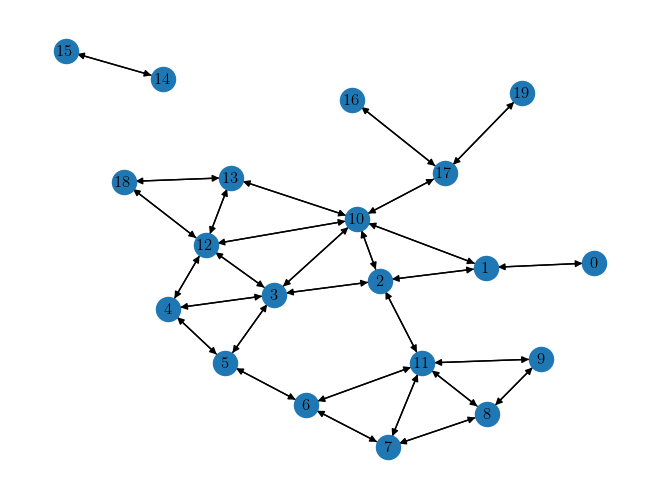

In [3]:
cogmap = LifelongCognitiveMap(None, load_data_from='plane.after_exploration.gpickle')
pc_network = cogmap.get_place_cell_network()
cogmap.draw()

In [4]:
from system.bio_model.grid_cell_model import GridCellNetwork
from system.controller.local_controller.local_navigation import create_gc_spiking
import numpy as np

gc_network = GridCellNetwork(from_data=True)
pc_firing = np.array(pc_network.compute_firing_values(gc_network))

pc_firings = {(0, 0): pc_firing}
for direction in [(0, 1), (1, 0), (-1, 0), (0, -1)]:
    new_gc_network = create_gc_spiking(start=(0, 0), goal=direction, gc_network_at_start=gc_network)
    pc_firings[direction] = np.array(pc_network.compute_firing_values(new_gc_network))

pybullet build time: Apr 30 2024 14:40:07


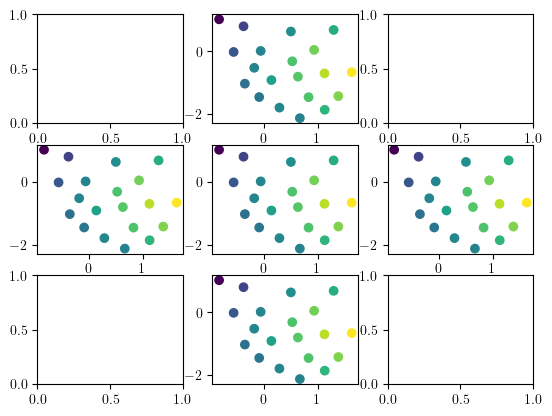

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3)

for i, direction in enumerate(pc_firings.keys()):
    firing = pc_firings[direction]
    axis = axes[direction[0]+1, direction[1]+1]
    axis.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=pc_firing)

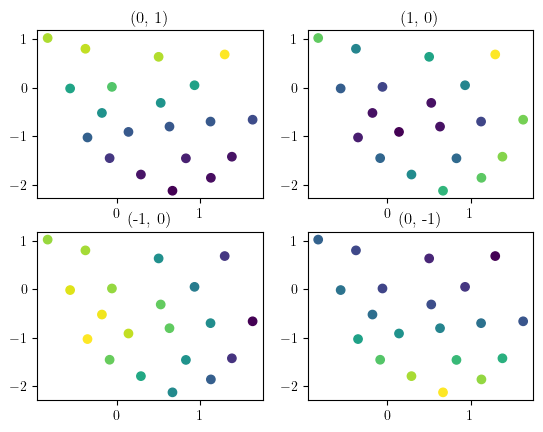

In [6]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, direction in enumerate(pc_firings.keys()):
    if direction == (0, 0):
        continue
    firing_diff = pc_firings[direction] - pc_firings[(0,0)]
    axis = axes[i-1]
    axis.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=firing_diff)
    axis.set_title(str(direction))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 14758.28it/s]


Average error: 0.2630740297935373


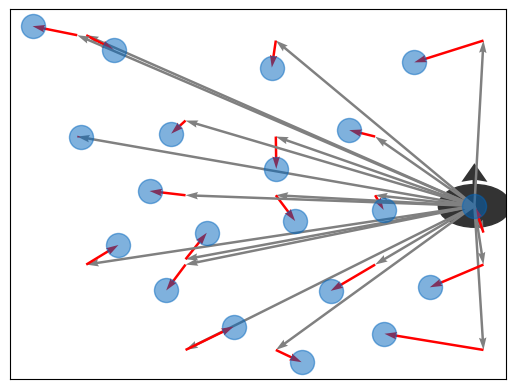

In [7]:
from system.controller.simulation.pybullet_environment import PybulletEnvironment

pc0 = pc_network.place_cells[0]
gc_network=GridCellNetwork(from_data=True)
gc_network.set_as_current_state(pc0.spikings)
cogmap.test_place_cell_network((pc0.pos, pc0.angle), arena_size=15, env_model='plane', gc_network=gc_network, display_freq=1)

## Correcting grid cell drift

In [8]:
from investigate_drift import MockEnv
env = MockEnv(start=pc0.pos, start_spikings=pc0.spikings, print_freq=1000)

In [28]:
norm_errors, angle_errors = env.go_to((0, 0))